In [15]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [27]:
MAX_WORDS = 15000
MAX_LEN = 120
TEST_SIZE = 0.20
RANDOM_STATE = 42
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 1e-3
EMBEDDING_DIM = 256
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
# Data preprocessing
def clean_text(text):
    if pd.isna(text):
        return ""
    return re.sub(r'[^a-zA-Z\s]', '', text.lower())

def load_and_preprocess_data():
    df = pd.read_csv("ReviewTokoBaju.csv")
    df = df.dropna(subset=['Review Text', 'Rating']).copy()
    df['Review Text'] = df['Review Text'].apply(clean_text)
    df['Rating'] = df['Rating'].apply(lambda x: 1 if x >= 4 else 0)

    # Balance the dataset
    count_0 = len(df[df['Rating']==0])
    count_1 = len(df[df['Rating']==1])

    if count_0 < count_1:
        df_min = df[df['Rating']==0]
        df_over = df_min.sample(count_1, replace=True, random_state=RANDOM_STATE)
        df = pd.concat([df[df['Rating']==1], df_over])
    else:
        df_min = df[df['Rating']==1]
        df_over = df_min.sample(count_0, replace=True, random_state=RANDOM_STATE)
        df = pd.concat([df[df['Rating']==0], df_over])

    df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

    return df

In [29]:
# Tokenizer implementation
class SimpleTokenizer:
    def __init__(self, num_words=MAX_WORDS, oov_token=''):
        self.num_words = num_words
        self.word_index = {}
        self.index_word = {}
        self.word_counts = {}
        self.oov_token = oov_token

    def fit_on_texts(self, texts):
        all_words = []
        for text in texts:
            words = text.split()
            for word in words:
                if word in self.word_counts:
                    self.word_counts[word] += 1
                else:
                    self.word_counts[word] = 1

        # Sort by frequency and get top words
        sorted_words = sorted(self.word_counts.items(), key=lambda x: x[1], reverse=True)
        sorted_words = sorted_words[:self.num_words-1]  # -1 for OOV token

        # Create word index (starting from 1, as 0 is padding)
        self.word_index = {word[0]: idx+1 for idx, word in enumerate(sorted_words)}
        # Add OOV token
        if self.oov_token:
            self.word_index[self.oov_token] = len(self.word_index) + 1

        # Create reverse mapping
        self.index_word = {v: k for k, v in self.word_index.items()}

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            words = text.split()
            seq = []
            for word in words:
                if word in self.word_index:
                    seq.append(self.word_index[word])
                elif self.oov_token:
                    seq.append(self.word_index[self.oov_token])
            sequences.append(seq)
        return sequences

In [30]:
def pad_sequences(sequences, maxlen=MAX_LEN):
    padded_sequences = []
    for seq in sequences:
        if len(seq) > maxlen:
            padded_sequences.append(seq[:maxlen])
        else:
            padded_sequences.append([0] * (maxlen - len(seq)) + seq)
    return padded_sequences

In [31]:
# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.LongTensor(sequences)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [38]:
# Deep RNN model definition
class DeepRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim=128, output_dim=1):
        super(DeepRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru1 = nn.GRU(embedding_dim, hidden_dim, batch_first=True, dropout=0.4)
        self.gru2 = nn.GRU(hidden_dim, hidden_dim//2, batch_first=True, dropout=0.3)
        self.gru3 = nn.GRU(hidden_dim//2, hidden_dim//4, batch_first=True, dropout=0.2)
        self.gru4 = nn.GRU(hidden_dim//4, hidden_dim//8, batch_first=True, dropout=0.2)

        self.fc = nn.Linear(hidden_dim//8, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc_out = nn.Linear(64, output_dim)

    def forward(self, text):
        # text = [batch size, sent len]
        embedded = self.embedding(text)
        # embedded = [batch size, sent len, emb dim]

        output1, _ = self.gru1(embedded)
        # output1 = [batch size, sent len, hid dim]

        output2, _ = self.gru2(output1)
        # output2 = [batch size, sent len, hid dim//2]

        output3, _ = self.gru3(output2)
        # output3 = [batch size, sent len, hid dim//4]

        _, hidden = self.gru4(output3)
        # hidden = [1, batch size, hid dim//8]

        dense = self.fc(hidden.squeeze(0))
        dense = torch.relu(dense)
        dense = self.dropout(dense)

        output = self.fc_out(dense)
        return torch.sigmoid(output)

In [39]:
# EarlyStopping implementation
class EarlyStopping:
    def __init__(self, patience=4, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

In [40]:
# Training function
def train(model, train_loader, val_loader, optimizer, criterion, epochs):
    early_stopping = EarlyStopping(patience=4)
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for batch_idx, (text, labels) in enumerate(train_loader):
            text, labels = text.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            predicted = (predictions > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch+1}/{epochs} | Batch: {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}')

        train_loss = epoch_loss / len(train_loader)
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for text, labels in val_loader:
                text, labels = text.to(DEVICE), labels.to(DEVICE)
                predictions = model(text).squeeze(1)
                loss = criterion(predictions, labels)

                val_loss += loss.item()
                val_total += labels.size(0)
                val_correct += ((predictions > 0.5).float() == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        # Early stopping
        if early_stopping(val_loss, model):
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(early_stopping.best_model)
            break

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs
    }

    return model, history

In [41]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []

    with torch.no_grad():
        for text, labels in test_loader:
            text = text.to(DEVICE)
            predictions = model(text).squeeze(1).cpu().numpy()
            y_prob.extend(predictions)
            y_pred.extend((predictions > 0.5).astype(int))
            y_true.extend(labels.numpy())

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)

    print(f"\nTest Accuracy: {acc:.4f}")
    print(f"Test Precision: {prec:.4f}")
    print(f"Test Recall: {rec:.4f}")
    print(f"Test F1: {f1:.4f}")
    print(f"Test AUC: {auc_score:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)

    return acc, prec, rec, f1, auc_score, fpr, tpr

In [42]:
# Plotting function
def plot_training(history):
    plt.figure(figsize=(14,5))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Deep RNN Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Deep RNN Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

def plot_roc(fpr, tpr, auc):
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'Deep RNN (AUC = {auc:.4f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

Using device: cuda
Dataset shape after preprocessing: (34896, 11)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(



=== Training Deep RNN model ===
Epoch: 1/10 | Batch: 0/186 | Loss: 0.6905
Epoch: 1/10 | Batch: 10/186 | Loss: 0.6728
Epoch: 1/10 | Batch: 20/186 | Loss: 0.6252
Epoch: 1/10 | Batch: 30/186 | Loss: 0.6252
Epoch: 1/10 | Batch: 40/186 | Loss: 0.5531
Epoch: 1/10 | Batch: 50/186 | Loss: 0.5518
Epoch: 1/10 | Batch: 60/186 | Loss: 0.4378
Epoch: 1/10 | Batch: 70/186 | Loss: 0.4795
Epoch: 1/10 | Batch: 80/186 | Loss: 0.4906
Epoch: 1/10 | Batch: 90/186 | Loss: 0.4858
Epoch: 1/10 | Batch: 100/186 | Loss: 0.4558
Epoch: 1/10 | Batch: 110/186 | Loss: 0.3810
Epoch: 1/10 | Batch: 120/186 | Loss: 0.3502
Epoch: 1/10 | Batch: 130/186 | Loss: 0.2988
Epoch: 1/10 | Batch: 140/186 | Loss: 0.3161
Epoch: 1/10 | Batch: 150/186 | Loss: 0.3734
Epoch: 1/10 | Batch: 160/186 | Loss: 0.3128
Epoch: 1/10 | Batch: 170/186 | Loss: 0.2806
Epoch: 1/10 | Batch: 180/186 | Loss: 0.3289
Epoch: 1/10 | Train Loss: 0.4680 | Train Acc: 0.7799 | Val Loss: 0.3313 | Val Acc: 0.8680
Epoch: 2/10 | Batch: 0/186 | Loss: 0.2771
Epoch: 2/1

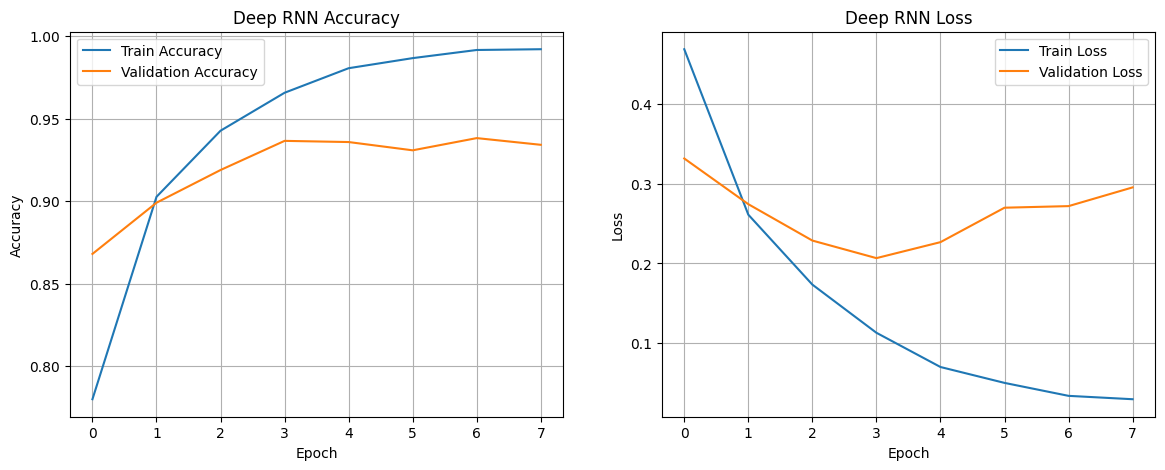

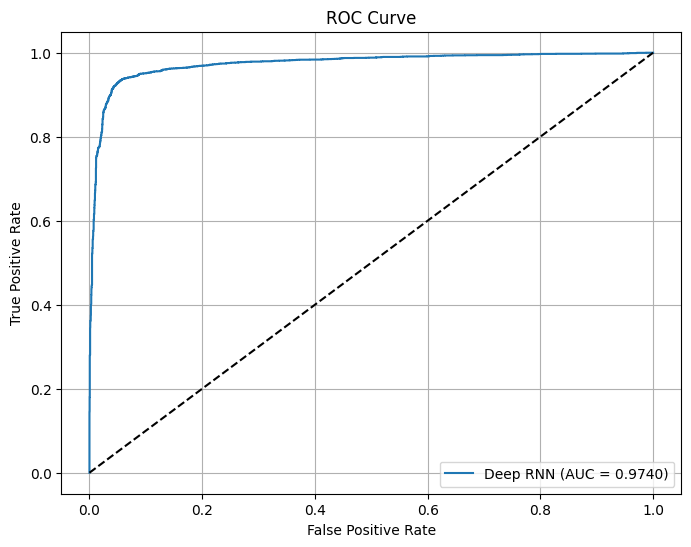


Model saved successfully.


In [43]:
def main():
    print(f"Using device: {DEVICE}")

    # Load and preprocess data
    df = load_and_preprocess_data()
    print(f"Dataset shape after preprocessing: {df.shape}")

    # Split data
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        df['Review Text'].values,
        df['Rating'].values,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=df['Rating'].values
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val,
        y_train_val,
        test_size=0.15,
        random_state=RANDOM_STATE,
        stratify=y_train_val
    )

    # Tokenize and pad sequences
    tokenizer = SimpleTokenizer(num_words=MAX_WORDS, oov_token='')
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
    X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN)
    X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

    # Create datasets and dataloaders
    train_dataset = TextDataset(X_train_pad, y_train)
    val_dataset = TextDataset(X_val_pad, y_val)
    test_dataset = TextDataset(X_test_pad, y_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = torch.FloatTensor(class_weights).to(DEVICE)

    # Initialize Deep RNN model
    vocab_size = min(len(tokenizer.word_index) + 1, MAX_WORDS)
    deep_rnn_model = DeepRNN(vocab_size, EMBEDDING_DIM).to(DEVICE)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    deep_rnn_optimizer = optim.Adam(deep_rnn_model.parameters(), lr=LEARNING_RATE)

    # Train Deep RNN model
    print("\n=== Training Deep RNN model ===")
    deep_rnn_model, history = train(deep_rnn_model, train_loader, val_loader, deep_rnn_optimizer, criterion, EPOCHS)

    # Evaluate Deep RNN model
    print("\n=== Evaluating Deep RNN model ===")
    acc, prec, rec, f1, auc, fpr, tpr = evaluate_model(deep_rnn_model, test_loader)

    # Plot results
    plot_training(history)
    plot_roc(fpr, tpr, auc)

    # Save model
    torch.save(deep_rnn_model.state_dict(), 'deep_rnn_model.pth')
    print("\nModel saved successfully.")

if __name__ == "__main__":
    main()